In [1]:
# dodawanie Google Drive'a (praca na Google Colab)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import bibliotek

import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import datasets
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# funkcja do pobierania zdjęć z folderu
# parametr no_to_load = ilość zdjęć do pobrania z każdego folderku (dla każdego owocka)

def load_from_folder(folder, only_path = False, label = "", no_to_load = 0):
    counter = 0
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
          counter+=1
          if counter > no_to_load:
            break
          img = plt.imread(os.path.join(folder,filename))
          if img is not None:
              images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
          counter+=1
          if counter > no_to_load:
            break
          img_path = os.path.join(folder,filename)
          if img_path is not None:
              path.append([label,img_path])
        return path

In [76]:
# lista folderów, w których są zdjecia na drivie

files = glob.glob(f"/content/drive/My Drive/Fruits/*")
for file_path in files:  
  print(file_path)

/content/drive/My Drive/Fruits/Banana
/content/drive/My Drive/Fruits/Mango
/content/drive/My Drive/Fruits/Pear
/content/drive/My Drive/Fruits/Orange
/content/drive/My Drive/Fruits/Apple
/content/drive/My Drive/Fruits/Test


In [80]:
print(type(files))
files.pop(-2)

<class 'list'>


'/content/drive/My Drive/Fruits/Mango'

In [85]:
# ładowanie zdjęć i ścieżek (wymagana cierpliwość, bo chwilę to trwa)

images = []

for file_path in files:
    if "png" in os.listdir(file_path)[0]:
        images += load_from_folder(file_path,True,label = file_path.split("/")[-1],no_to_load =500)

In [86]:
# tworzenie df ze ścieżkami i etykietami dla każdego owocu

df = pd.DataFrame(images, columns = ["fruit", "path"])

In [87]:
# mieszanie datasetu
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Przypisanie każdemu owocowi etykiety z numerem
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1}


In [88]:
df.head()

,fruit,path,label
0,Apple,/content/drive/My Drive/Fruits/Apple/Apple 061...,0
1,Apple,/content/drive/My Drive/Fruits/Apple/Apple 041...,0
2,Banana,/content/drive/My Drive/Fruits/Banana/Banana03...,1
3,Apple,/content/drive/My Drive/Fruits/Apple/Apple 027...,0
4,Apple,/content/drive/My Drive/Fruits/Apple/Apple 027...,0


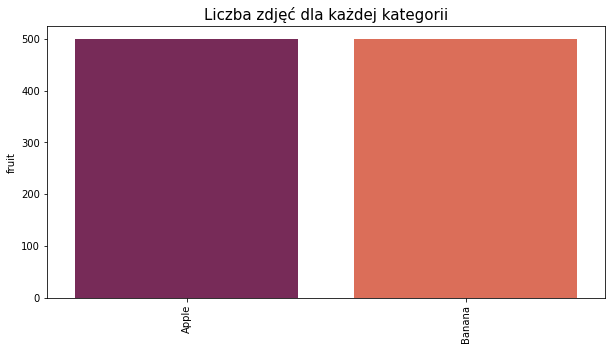

In [89]:
# prezentacja liczności poszczególnych klas

value_cnt = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = value_cnt.index, y = value_cnt, palette = "rocket")
plt.title("Liczba zdjęć dla każdej kategorii", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

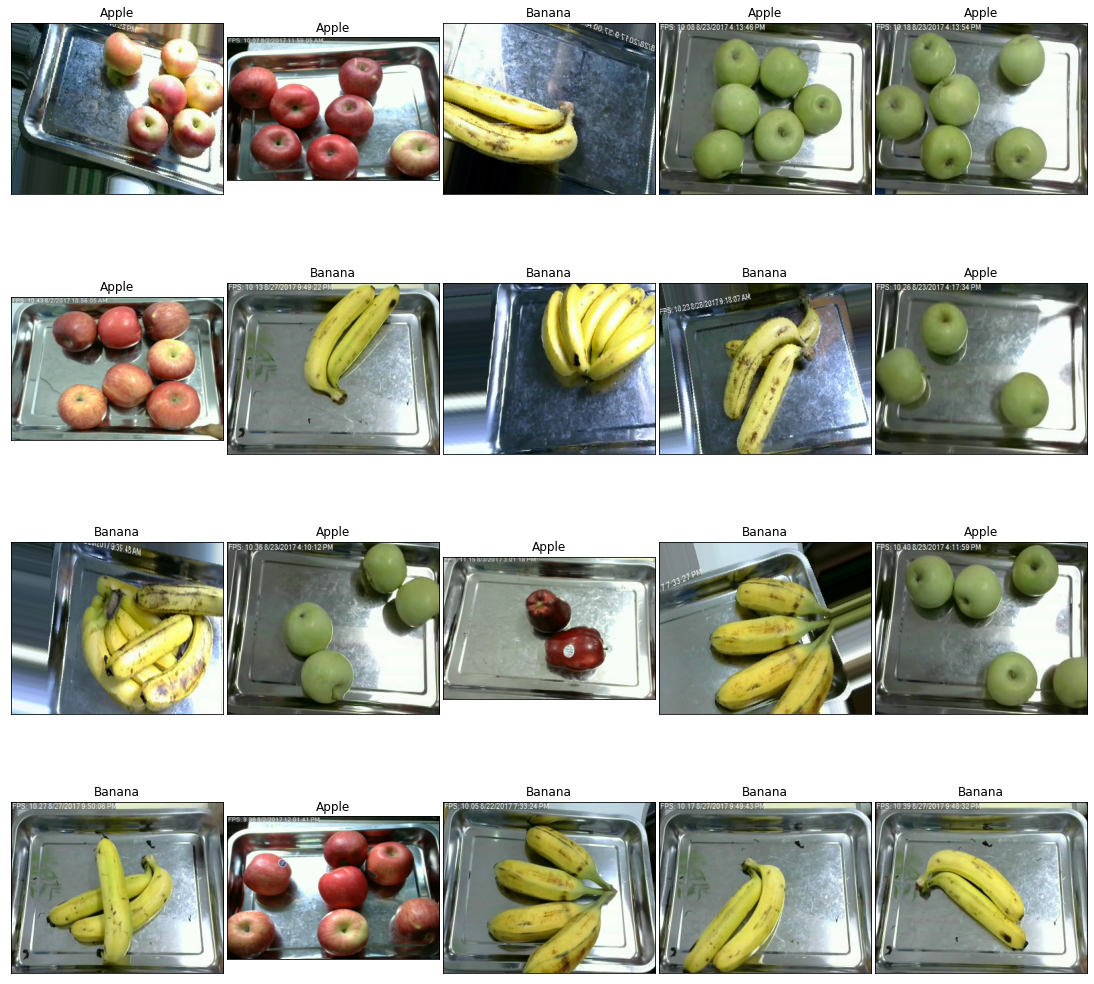

In [90]:
# wyświetlenie kilku przykładowych zdjęć - widać, że zdjęcia są różnej wielkości

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

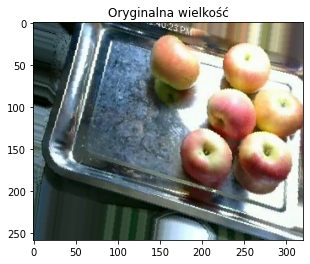

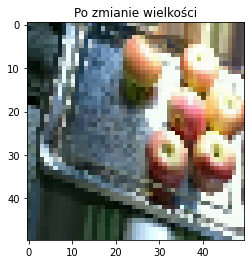

In [91]:
# testowanie skalowania zdjęć do jednego rozmiaru

img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Oryginalna wielkość")
plt.show()

plt.imshow(cv2.resize(img, (50, 50)))
plt.title("Po zmianie wielkości")
plt.show()

In [107]:
# przygotowanie funkcji do skalowania i ładowania zdjęć

def load_imgages(df):
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img_org =  plt.imread(path)
        img = cv2.resize(img_org, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),(np.array(y).reshape(-1,1))

In [93]:
img_paths = df["path"].values
img_labels = df["label"].values

print(img_paths[:3])
print(img_labels[:3])

['/content/drive/My Drive/Fruits/Apple/Apple 0611.png'
 '/content/drive/My Drive/Fruits/Apple/Apple 0410.png'
 '/content/drive/My Drive/Fruits/Banana/Banana0339.png']
[0 0 1]


In [108]:
# załadowanie danych do X i y

X, y = load_imgages(df)

print(f"X shape: {X.shape}\n\n y shape: {y.shape}")

X shape: (1000, 150, 150, 3)

 y shape: (1000, 1)


In [109]:
# podział na zbiór treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (800, 150, 150, 3)
X_test shape:  (200, 150, 150, 3)
y_train shape:  (800, 1)
y_test shape:  (200, 1)


In [110]:
# normalizacja danych na zakres 0-1

X_train, X_test = X_train / 255.0, X_test / 255.0

In [111]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [112]:
# tranformacja y przy pomocy one hot encodingu

y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# sprawdzenie czy OHE zadziałało jak powinno (kształt się zmienił)
print(f"Shape etykiet treningowych:{y_train.shape}\nShape etykiet testowych: {y_test.shape}")

Shape etykiet treningowych:(800, 2)
Shape etykiet testowych: (200, 2)


In [117]:
# budowa modelu CNN

def define_model():
    model = models.Sequential()
    model.add(layers.Conv2D(150, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
    model.add(layers.Conv2D(150, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(300, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(300, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(600, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    print(model.summary())
    
    # compile model
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer=opt, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [118]:
model_cnn = define_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 150, 150, 150)     4200      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 150, 150, 150)     202650    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 150)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 300)       405300    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 75, 75, 300)       810300    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 300)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 410700)           

In [119]:
# trening 

history = model_cnn.fit(
    x=X_train,
    y=y_train,
    batch_size=50,
    epochs=20,
    validation_split=0.1
)

Epoch 1/20
15/15 [==============================] - 10s 659ms/step - loss: 0.6932 - accuracy: 0.5191 - val_loss: 0.6922 - val_accuracy: 0.6500
Epoch 2/20
15/15 [==============================] - 10s 649ms/step - loss: 0.6883 - accuracy: 0.7391 - val_loss: 0.6725 - val_accuracy: 0.6125
Epoch 3/20
15/15 [==============================] - 10s 656ms/step - loss: 0.6196 - accuracy: 0.7119 - val_loss: 0.6107 - val_accuracy: 0.7375
Epoch 4/20
15/15 [==============================] - 10s 662ms/step - loss: 0.4278 - accuracy: 0.8239 - val_loss: 0.4567 - val_accuracy: 0.8000
Epoch 5/20
15/15 [==============================] - 10s 666ms/step - loss: 0.2857 - accuracy: 0.8863 - val_loss: 0.4010 - val_accuracy: 0.8875
Epoch 6/20
15/15 [==============================] - 10s 670ms/step - loss: 0.2411 - accuracy: 0.9115 - val_loss: 0.3368 - val_accuracy: 0.8875
Epoch 7/20
15/15 [==============================] - 10s 673ms/step - loss: 0.1922 - accuracy: 0.9394 - val_loss: 0.3650 - val_accuracy: 0.8625

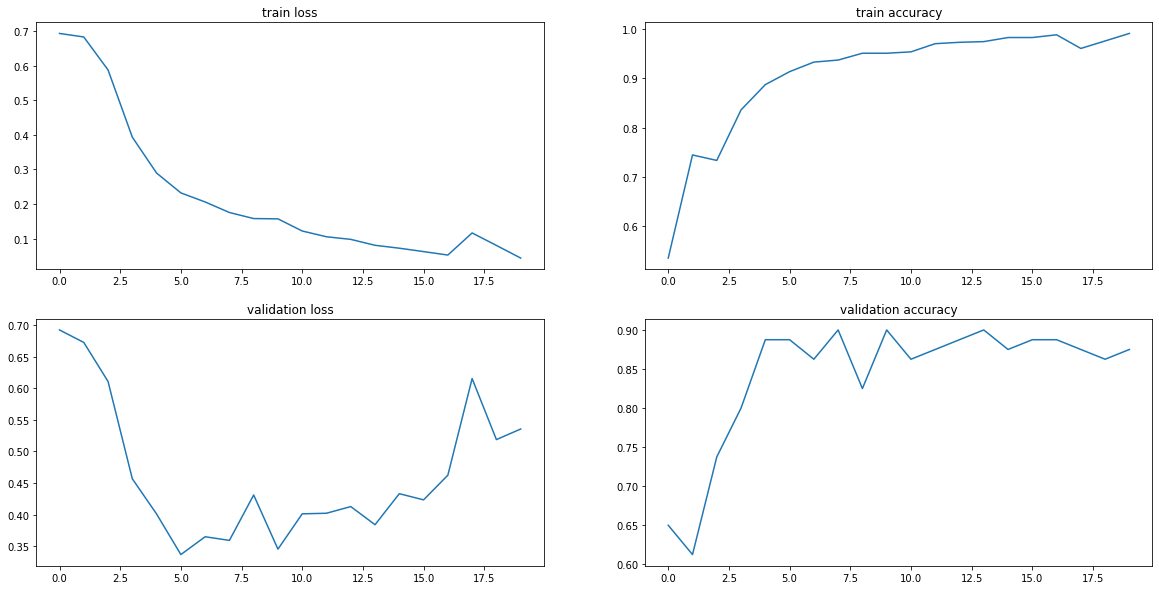

In [120]:
# wykresy porównujące jakość modelu na treningu i walidacji

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [121]:
y_pred = model_cnn.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       109
           1       0.90      0.89      0.90        91

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

[[100   9]
 [ 10  81]]


In [122]:
print(y_test.argmax(axis=1), y_pred.argmax(axis=1))

[0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0
 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0
 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0] [0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1
 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1
 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0
 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0]
